In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import os
import glob
import zipfile
from time import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 1. UNZIP AND LOAD FILE PATHS
zip_path = "/content/segmentation_data.zip"
extract_path = "/content/segmentation_data"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print(f"Extracting {zip_path} to {extract_path}...")
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print(f"Directory {extract_path} already exists. Skipping extraction.")

images_path = "/content/segmentation_data/segmentation_data/Original Images"
masks_path  = "/content/segmentation_data/segmentation_data/Original Masks"

image_files = sorted(glob.glob(os.path.join(images_path, "*.tif")))
mask_files  = sorted(glob.glob(os.path.join(masks_path, "*.tif")))

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

Directory /content/segmentation_data already exists. Skipping extraction.
Found 22 images and 22 masks


Visualizing samples from the Dataset (after transforms)...


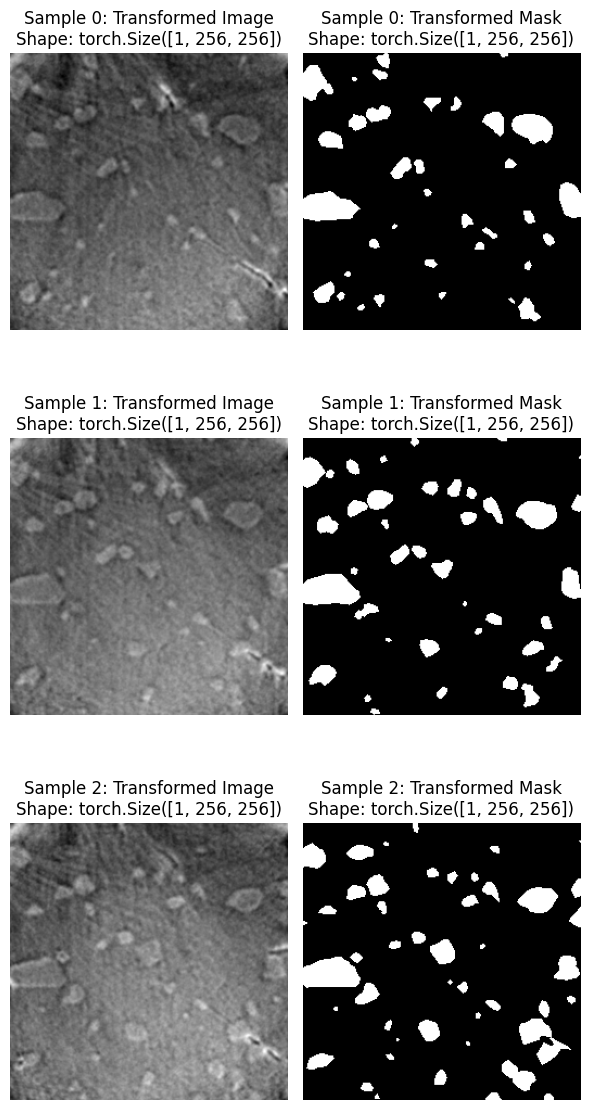


--- Analyzing Pixel Counts for a Single Mask (Sample 0) ---
Analyzing Sample 0 (after transforms):
Total Pixels: 65536
Pore (1.0) Pixels:   6211 (9.48%)
Background (0.0) Pixels: 59325 (90.52%)


In [ ]:
# 2. DATASET CLASS AND TRANSFORMS

class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None, mask_transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        self.mask_transform = mask_transform
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        # Load BOTH as-is (float images), do NOT use .convert()
        image = Image.open(img_path)
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

import numpy as np

# 1. NEW IMAGE TRANSFORM

# This transform will resize, then perform min-max normalization
# to stretch the contrast, just like your example code.

def normalize_image_transform(img):
    """Normalizes a float PIL image to a [0, 1] tensor."""
    # Convert PIL image to numpy array
    np_img = np.array(img, dtype=np.float32)

    # Get min/max for normalization
    min_val = np.min(np_img)
    max_val = np.max(np_img)

    # Perform min-max normalization (contrast stretching)
    # Add 1e-6 to prevent division by zero if image is all one color
    if max_val - min_val > 1e-6:
        normalized_img = (np_img - min_val) / (max_val - min_val)
    else:
        # If image is solid, just set to 0
        normalized_img = np.zeros(np_img.shape, dtype=np.float32)

    # Add channel dimension and return as float tensor
    return torch.from_numpy(normalized_img).unsqueeze(0)


image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(normalize_image_transform),   # <--- use this, like AE
])


# 2. MASK TRANSFORM (Stays the same as before)

# This transform resizes, then converts the float data to a binary
# 0/1 mask based on a threshold (pixel > 0)

mask_transform = transforms.Compose([
    # Use NEAREST for resizing masks (preserves labels)
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img) <= 0).unsqueeze(0).float())
])

# 1. Create a temporary dataset instance to test the transforms
print("Visualizing samples from the Dataset (after transforms)...")
viz_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

# 2. Plot the first 3 samples
n_samples_to_plot = 3
plt.figure(figsize=(6, n_samples_to_plot * 4))

for i in range(n_samples_to_plot):
    # Get the transformed image and mask tensors
    image_tensor, mask_tensor = viz_dataset[i]

    # Squeeze() removes the channel dimension [1, 256, 256] -> [256, 256]
    # .numpy() converts the tensor for plotting

    # a) Transformed Image
    plt.subplot(n_samples_to_plot, 2, i*2 + 1)
    plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Image\nShape: {image_tensor.shape}")
    plt.axis('off')

    # b) Transformed (Thresholded) Mask
    plt.subplot(n_samples_to_plot, 2, i*2 + 2)
    plt.imshow(mask_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Mask\nShape: {mask_tensor.shape}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Pixel Count for a Single Mask
print("\n--- Analyzing Pixel Counts for a Single Mask (Sample 0) ---")

# 1. Get a single sample (the first one) from the dataset
# This applies the mask_transform, so the mask is already 0s and 1s
image_tensor, mask_tensor = viz_dataset[0]

# 2. Count the pixels
#    .sum() adds up all the 1.0s
pore_pixels = mask_tensor.sum().item()

#    .numel() gets the total number of elements
total_pixels = mask_tensor.numel()

#    The rest must be 0.0s
background_pixels = total_pixels - pore_pixels

# 3. Print the results
pore_percentage = (pore_pixels / total_pixels) * 100
bg_percentage = (background_pixels / total_pixels) * 100

print(f"Analyzing Sample 0 (after transforms):")
print(f"Total Pixels: {int(total_pixels)}")
print(f"Pore (1.0) Pixels:   {int(pore_pixels)} ({pore_percentage:.2f}%)")
print(f"Background (0.0) Pixels: {int(background_pixels)} ({bg_percentage:.2f}%)")

In [ ]:
# 3. DATASET SPLITTING AND DATALOADERS
full_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

# Split
torch.manual_seed(42) # for reproducible splits
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created.")

Total samples: 22
Training samples: 17
Validation samples: 2
Test samples: 3

DataLoaders created.


INPUT stats -> min: 4.5226064685266465e-05 max: 0.0004311995580792427 mean: 0.00019753779633902013 std: 4.0973427530843765e-05


In [ ]:
# 4. SANITY CHECK
try:
    images, masks = next(iter(train_loader))
    print(f"Images batch shape: {images.shape}")  # Should be [B, 1, 256, 256]
    print(f"Masks batch shape:  {masks.shape}")   # Should be [B, 1, 256, 256]
    print(f"Mask tensor data type: {masks.dtype}")
    print(f"Mask min value: {masks.min()}")
    print(f"Mask max value: {masks.max()}")
    print(f"Unique mask values in batch: {torch.unique(masks)}")
except (StopIteration, NameError):
    print("ERROR: Could not fetch a batch from train_loader. Check data paths/splitting.")

Images batch shape: torch.Size([8, 1, 256, 256])
Masks batch shape:  torch.Size([8, 1, 256, 256])
Mask tensor data type: torch.float32
Mask min value: 0.0
Mask max value: 1.0
Unique mask values in batch: tensor([0., 1.])


# **VARIATIONAL AUTOENCODER**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class DeconvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_c, out_c)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        return x

class ImprovedVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        # ---- Encoder: 3 downsamplings -> 32x32 ----
        self.enc1 = ConvBlock(1, 32)          # 256x256
        self.pool1 = nn.MaxPool2d(2)          # 128x128

        self.enc2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)          # 64x64

        self.enc3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)          # 32x32

        # bottleneck feature map: 128 x 32 x 32
        self.flatten = nn.Flatten()
        flat_dim = 128 * 32 * 32

        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)

        # ---- Decoder ----
        self.fc_dec = nn.Linear(latent_dim, flat_dim)

        self.dec3 = ConvBlock(128, 128)   # keep 32x32
        self.up2  = DeconvBlock(128, 64)  # 32 -> 64
        self.up1  = DeconvBlock(64, 32)   # 64 -> 128
        self.up0  = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # 128 -> 256
        self.out_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)

        # final activation for [0,1] images
        self.out_act = nn.Sigmoid()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.enc1(x)
        x = self.pool1(x)
        x = self.enc2(x)
        x = self.pool2(x)
        x = self.enc3(x)
        x = self.pool3(x)

        h = self.flatten(x)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z):
        h = self.fc_dec(z)
        x = h.view(-1, 128, 32, 32)

        x = self.dec3(x)
        x = self.up2(x)
        x = self.up1(x)
        x = self.up0(x)
        x = self.out_conv(x)
        x = self.out_act(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar



In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- VAE LOSS FUNCTION ---------
def vae_loss(x, x_hat, mu, logvar, beta=0.01):
  #beta = 0.01 This reduces regularisation even more → closer to AE behaviour,
  #slightly sharper reconstructions, but the latent space becomes less nicely Gaussian.
  #also tried w/ 1.0, 0.1
    """
    VAE loss:
      - recon_loss: per-pixel MSE (like your AE)
      - kl_loss: KL divergence, normalized per pixel
      - beta: weight of the KL term
    Returns: total_loss, recon_loss, kl_loss
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(x_hat, x, reduction='mean')

    # KL divergence (sum over batch & latent dim)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Normalize KL to per-pixel scale (B * H * W, assuming 1 channel)
    n_pixels = x.size(0) * x.size(2) * x.size(3)
    kl = kl / n_pixels

    # Total loss
    loss = recon_loss + beta * kl

    return loss, recon_loss, kl

#MODEL + OPTIMIZER
latent_dim = 512 ## get some extra detail, but it’s diminishing returns
model = ImprovedVAE(latent_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 80
train_loss_history = []
val_loss_history = []

print("Starting VAE Training...")

for epoch in range(num_epochs):
    model.train()
    batch_losses = []

    #TRAINING
    for images, masks in train_loader:
        images = images.to(device).float()

        optimizer.zero_grad()
        x_hat, mu, logvar = model(images)

        loss, recon_loss, kl_loss = vae_loss(images, x_hat, mu, logvar, beta=0.01)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    avg_train_loss = np.mean(batch_losses)
    train_loss_history.append(avg_train_loss)

    #VALIDATION
    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device).float()
            x_hat, mu, logvar = model(images)
            val_loss, _, _ = vae_loss(images, x_hat, mu, logvar, beta=0.01)
            val_batch_losses.append(val_loss.item())

    avg_val_loss = np.mean(val_batch_losses)
    val_loss_history.append(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}"
        )

print("VAE Training Complete.")




Starting VAE Training...
Epoch [5/80] | Train Loss: 0.02865 | Val Loss: 0.02870
Epoch [10/80] | Train Loss: 0.02534 | Val Loss: 0.02713
Epoch [15/80] | Train Loss: 0.01556 | Val Loss: 0.01355
Epoch [20/80] | Train Loss: 0.01650 | Val Loss: 0.00820
Epoch [25/80] | Train Loss: 0.01592 | Val Loss: 0.00830
Epoch [30/80] | Train Loss: 0.01253 | Val Loss: 0.00755
Epoch [35/80] | Train Loss: 0.01026 | Val Loss: 0.00816
Epoch [40/80] | Train Loss: 0.01125 | Val Loss: 0.00816
Epoch [45/80] | Train Loss: 0.01025 | Val Loss: 0.00683
Epoch [50/80] | Train Loss: 0.00947 | Val Loss: 0.00836
Epoch [55/80] | Train Loss: 0.00963 | Val Loss: 0.00629
Epoch [60/80] | Train Loss: 0.00860 | Val Loss: 0.00607
Epoch [65/80] | Train Loss: 0.00725 | Val Loss: 0.00551
Epoch [70/80] | Train Loss: 0.00643 | Val Loss: 0.00567
Epoch [75/80] | Train Loss: 0.00579 | Val Loss: 0.00546
Epoch [80/80] | Train Loss: 0.00590 | Val Loss: 0.00506
VAE Training Complete.
VAE Training Complete.


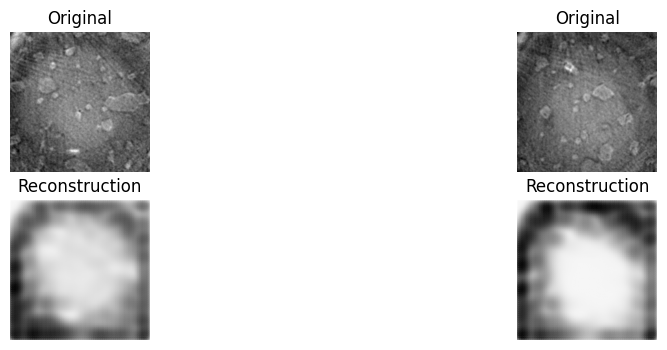

In [ ]:
model.eval()

with torch.no_grad():
    images, _ = next(iter(val_loader))
    images = images.to(device)
    x_hat, _, _ = model(images)

# Convert to numpy
images = images.cpu().numpy()
x_hat = x_hat.cpu().numpy()

batch_size = images.shape[0]
n_show = min(batch_size, 4)   # show max 4 samples

plt.figure(figsize=(12, 4))

for i in range(n_show):
    # Original
    plt.subplot(2, n_show, i + 1)
    plt.imshow(images[i, 0], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstruction
    plt.subplot(2, n_show, i + 1 + n_show)
    plt.imshow(x_hat[i, 0], cmap='gray')
    plt.title("Reconstruction")
    plt.axis('off')

plt.show()



In [ ]:
images, _ = next(iter(val_loader))
images = images.to(device).float()
x_hat, mu, logvar = model(images)

print("INPUT  stats  -> min:", images.min().item(),
      "max:", images.max().item(),
      "mean:", images.mean().item(),
      "std:", images.std().item())

print("X_HAT stats  -> min:", x_hat.min().item(),
      "max:", x_hat.max().item(),
      "mean:", x_hat.mean().item(),
      "std:", x_hat.std().item())


INPUT  stats  -> min: 0.0 max: 1.0 mean: 0.39389699697494507 std: 0.11426889151334763
X_HAT stats  -> min: 0.162260040640831 max: 0.5139118432998657 mean: 0.3998810052871704 std: 0.07976548373699188


VAE W/ SKIPPED CONNECTION - VAE + UNET -- We still have the probabilistic bottleneck, but the decoder also receives encoder feature maps via skip connections to better preserve local details (like the pores).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class SkipVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        # ------------ Encoder ------------
        self.enc1 = ConvBlock(1, 32)           # 256x256
        self.pool1 = nn.MaxPool2d(2)           # 128x128

        self.enc2 = ConvBlock(32, 64)          # 128x128
        self.pool2 = nn.MaxPool2d(2)           # 64x64

        self.enc3 = ConvBlock(64, 128)         # 64x64
        self.pool3 = nn.MaxPool2d(2)           # 32x32

        # bottleneck: 128 x 32 x 32
        self.flatten = nn.Flatten()
        flat_dim = 128 * 32 * 32

        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)

        # ------------ Decoder ------------
        self.fc_dec = nn.Linear(latent_dim, flat_dim)

        # bottom (32x32)
        self.dec3 = ConvBlock(128, 128)

        # up to 64x64, concat skip3 (128 + 128 -> 256 -> 64)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)    # 32 -> 64
        self.dec2 = ConvBlock(64 + 128, 64)

        # up to 128x128, concat skip2 (64 + 64 -> 128 -> 32)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)     # 64 -> 128
        self.dec1 = ConvBlock(32 + 64, 32)

        # up to 256x256, concat skip1 (32 + 32 -> 64 -> 16)
        self.up0 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)     # 128 -> 256
        self.dec0 = ConvBlock(16 + 32, 16)

        self.out_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.out_act = nn.Sigmoid()  # images in [0, 1]

    # reparameterization trick
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        # encoder with skips
        x1 = self.enc1(x)           # 32 x 256 x 256
        p1 = self.pool1(x1)         # 32 x 128 x 128

        x2 = self.enc2(p1)          # 64 x 128 x 128
        p2 = self.pool2(x2)         # 64 x 64 x 64

        x3 = self.enc3(p2)          # 128 x 64 x 64
        p3 = self.pool3(x3)         # 128 x 32 x 32

        h = self.flatten(p3)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        skips = (x1, x2, x3)
        return mu, logvar, skips

    def decode(self, z, skips):
        x1, x2, x3 = skips

        h = self.fc_dec(z)
        x = h.view(-1, 128, 32, 32)

        # bottom
        x = self.dec3(x)  # 128 x 32 x 32

        # up to 64x64 + skip3
        x = self.up2(x)              # 64 x 64 x 64
        x = torch.cat([x, x3], dim=1)  # (64+128)=192 x 64 x 64
        x = self.dec2(x)             # 64 x 64 x 64

        # up to 128x128 + skip2
        x = self.up1(x)              # 32 x 128 x 128
        x = torch.cat([x, x2], dim=1)  # (32+64)=96 x 128 x 128
        x = self.dec1(x)             # 32 x 128 x 128

        # up to 256x256 + skip1
        x = self.up0(x)              # 16 x 256 x 256
        x = torch.cat([x, x1], dim=1)  # (16+32)=48 x 256 x 256
        x = self.dec0(x)             # 16 x 256 x 256

        x = self.out_conv(x)
        x = self.out_act(x)
        return x

    def forward(self, x):
        mu, logvar, skips = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, skips)
        return x_hat, mu, logvar


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- VAE LOSS FUNCTION ---------
def vae_loss(x, x_hat, mu, logvar, beta=0.01):
  #beta = 0.01 This reduces regularisation even more → closer to AE behaviour,
  #slightly sharper reconstructions, but the latent space becomes less nicely Gaussian.
  #also tried w/ 1.0, 0.1
    """
    VAE loss:
      - recon_loss: per-pixel MSE
      - kl_loss: KL divergence, normalized per pixel
      - beta: weight of the KL term
    Returns: total_loss, recon_loss, kl_loss
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(x_hat, x, reduction='mean')

    # KL divergence (sum over batch & latent dim)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Normalize KL to per-pixel scale (B * H * W, assuming 1 channel)
    n_pixels = x.size(0) * x.size(2) * x.size(3)
    kl = kl / n_pixels

    # Total loss
    loss = recon_loss + beta * kl

    return loss, recon_loss, kl

#MODEL + OPTIMIZER
latent_dim = 512 ## get some extra detail, but it’s diminishing returns
model = SkipVAE(latent_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 80
train_loss_history = []
val_loss_history = []

print("Starting VAE + SKIP Training...")

for epoch in range(num_epochs):
    model.train()
    batch_losses = []

    #TRAINING
    for images, masks in train_loader:
        images = images.to(device).float()

        optimizer.zero_grad()
        x_hat, mu, logvar = model(images)

        loss, recon_loss, kl_loss = vae_loss(images, x_hat, mu, logvar, beta=0.01)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    avg_train_loss = np.mean(batch_losses)
    train_loss_history.append(avg_train_loss)

    #VALIDATION
    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device).float()
            x_hat, mu, logvar = model(images)
            val_loss, _, _ = vae_loss(images, x_hat, mu, logvar, beta=0.01)
            val_batch_losses.append(val_loss.item())

    avg_val_loss = np.mean(val_batch_losses)
    val_loss_history.append(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}"
        )

print("VAE + UNET Training Complete.")


Starting VAE + UNET Training...
Epoch [5/80] | Train Loss: 0.02474 | Val Loss: 0.02398
Epoch [10/80] | Train Loss: 0.03013 | Val Loss: 0.02184
Epoch [15/80] | Train Loss: 0.02014 | Val Loss: 0.01832
Epoch [20/80] | Train Loss: 0.01634 | Val Loss: 0.01501
Epoch [25/80] | Train Loss: 0.01629 | Val Loss: 0.01397
Epoch [30/80] | Train Loss: 0.01166 | Val Loss: 0.01009
Epoch [35/80] | Train Loss: 0.01174 | Val Loss: 0.00959
Epoch [40/80] | Train Loss: 0.01018 | Val Loss: 0.00692
Epoch [45/80] | Train Loss: 0.00818 | Val Loss: 0.00546
Epoch [50/80] | Train Loss: 0.00688 | Val Loss: 0.00457
Epoch [55/80] | Train Loss: 0.00500 | Val Loss: 0.00348
Epoch [60/80] | Train Loss: 0.00397 | Val Loss: 0.00264
Epoch [65/80] | Train Loss: 0.00278 | Val Loss: 0.00216
Epoch [70/80] | Train Loss: 0.00279 | Val Loss: 0.00180
Epoch [75/80] | Train Loss: 0.00275 | Val Loss: 0.00147
Epoch [80/80] | Train Loss: 0.00119 | Val Loss: 0.00134
VAE + UNET Training Complete.


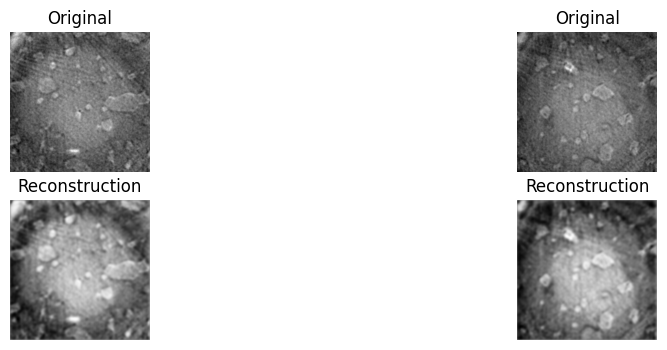

In [ ]:
model.eval()

with torch.no_grad():
    images, _ = next(iter(val_loader))
    images = images.to(device)
    x_hat, _, _ = model(images)

# Convert to numpy
images = images.cpu().numpy()
x_hat = x_hat.cpu().numpy()

batch_size = images.shape[0]
n_show = min(batch_size, 4)   # show max 4 samples

plt.figure(figsize=(12, 4))

for i in range(n_show):
    # Original
    plt.subplot(2, n_show, i + 1)
    plt.imshow(images[i, 0], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstruction
    plt.subplot(2, n_show, i + 1 + n_show)
    plt.imshow(x_hat[i, 0], cmap='gray')
    plt.title("Reconstruction")
    plt.axis('off')

plt.show()
